# Practice: Recurrent neural networks for cognitive tasks

The objective of this practice is to learn how to build a model of neural activity called the Recurrent Neural Network (RNN). 

In this model, each neuron of index $i$ has a time-dependent membrane voltage $x_i(t)$, and produces a firing rate $\phi(x_i(t))$, where $\phi$ is a non-linearity (here we will take the hyperbolic tangent tanh). Moreover, our network of neurons is recurrently connected and each pair of neurons $(i, j)$ has a synaptic connexion of weight $J_{ij}$. There are also $P$ external input signals $u_k(t)$ that are fed to neuron $i$ through the synaptic weight $B_{ik}$. Finally, each neuron integrates the firing rate of all its inputs into its voltage via the differential equation:

$$\dot{x}_i = -x_i(t) + \sum_{j=1}^N J_{ij}\phi(x_j(t)) + \sum_{k=1}^P B_{ik}u_k(t)$$

The outputs of the network will be linear readouts from the rates:

$$z_k(t) = \sum_{j=1}^N W_{kj} \phi(x_j(t))$$

In the end, the parameters of this model are all the synaptic weights, $J_{ij}$, $B_{ik}$, $W_{kj}$. It turns out that they can be trained via the backpropagation algorithm to match any input-output mapping.

# Build an RNN model in pytorch

We first have to discretize this differential equation with the Euler method, which gives the following recurrence equation for voltages:

$$x_{i, t+1} = (1 - \Delta t)x_{i, t} + \Delta t (\sum_{j=1}^N J_{ij}\phi(x_{j, t}) + \sum_{k=1}^P B_{ik}u_{k, t})$$

with $\Delta t$ the timestep chosen for the simulation. We can write it in vector form by considering $\mathbf{x}_t = (x_{i, t})_{i=1..n}$ the vector of voltages for all neurons of the network at time $t$. This gives the equation:

$$\mathbf{x}_{t+1} = (1 - \Delta t)\mathbf{x}_{t} + \Delta t (\mathbf{J} \phi(\mathbf{x}_t) + \mathbf{B} \mathbf{u}_t)$$

The first step is to create a Network class that will have a method __init__ containing the parameters of the network, and a method forward(input) that will effectively run the network with some inputs. Fill in the gaps (dots) in the following class definition so that the network follows the equation above.

In [1]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class RNN(nn.Module):
    
    def __init__(self, input_dim, size, output_dim, deltaT, init_std=1.):
        """
        Initialize an RNN
        
        parameters:
        input_dim: int
        size: int
        output_dim: int
        deltaT: float
        init_std: float, initialization variance for the connectivity matrix
        """
        # Setting some internal variables
        super(RNN, self).__init__()  # pytorch administration line
        self.input_dim = input_dim
        self.size = size
        self.output_dim = output_dim
        self.deltaT = deltaT
        
        # Defining the parameters of the network
        self.B = nn.Parameter(torch.Tensor(size, input_dim))  # input weights
        self.J = nn.Parameter(torch.Tensor(size, size))   # connectivity matrix
        self.W = nn.Parameter(torch.Tensor(output_dim, size))  # output matrix
        
        # Initializing the parameters to some random values
        with torch.no_grad():  # this is to say that initialization will not be considered when computing the gradient later on
            self.B.normal_()
            self.J.normal_(std=init_std)
            self.W.normal_()
            
    def forward(self, inputs, initial_state=None):
        """
        Run the RNN with input for one trial
        
        parameters:
        inp: torch tensor of shape (duration x input_dim)
        initial_state: None or torch tensor of shape (input_dim)
        
        returns:
        x_seq: sequence of voltages, torch tensor of shape ((duration+1) x net_size)
        output_seq: torch tensor of shape (duration x output_dim)
        """
        print(type(inputs))
        T = inputs.shape[0]  # duration of the trial
        x_seq = torch.zeros(T + 1, self.size)  # this will contain the sequence of voltage throughout the trial for the whole population
        # by default the network starts with x_i=0 at time t=0 for all neurons
        if initial_state is not None:
            x_seq[0] = initial_state
        output_seq = torch.zeros(T, self.output_dim)  # contains the sequence of output values z_{k, t} throughout the trial
        
        # loop through time
        for t in range(T):
            x_seq[t+1] = (1 - self.deltaT) * x_seq[t] + self.deltaT * (self.J @ torch.tanh(x_seq[t]) + self.B @ inputs[t])
            output_seq[t] = self.W @ torch.tanh(x_seq[t+1])  # FILL HERE
        
        return x_seq, output_seq
        
        

In [3]:
# Creation of a network with randomly initialized weights:

net_size = 128
deltaT = .2
my_net = RNN(1, net_size, 1, deltaT)

In [4]:
# Let us run it with some constant input for a duration T=200 steps:
T = 200
inp = torch.ones(T, 1)  # the tensor containing inputs should have a shape (duration x input_dim), even if input_dim is 1.

x_seq, output_seq = my_net.forward(inp)  # this effectively runs the simulation
rates_seq = torch.tanh(x_seq)  # we also retrieve rates easily from the sequence of voltages

x_seq = x_seq.detach().squeeze().numpy()  # useful line for detaching the sequences from pytorch gradients (we will see that later)
output_seq = output_seq.detach().squeeze().numpy()
rates_seq = rates_seq.detach().squeeze().numpy()

# looking at the shapes of the obtained data
print(x_seq.shape)
print(output_seq.shape)

<class 'torch.Tensor'>
(201, 128)
(200,)


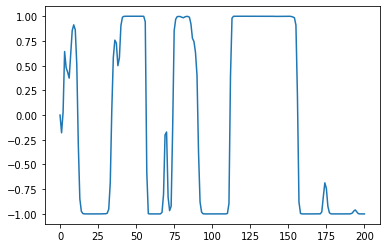

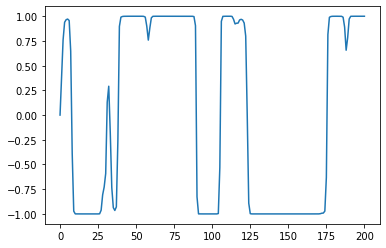

In [5]:
# CORR

# Visualizing the trajectories for some neurons
def plot_neuron_rate(neuron_idx, rates_seq):
    """
    parameters:
    neuron_idx: int
    rates_seq: numpy array of shape (duration x net_size)
    """
    T = x_seq.shape[0]
    plt.plot(np.arange(T), rates_seq[:, neuron_idx])
    plt.show()
    
plot_neuron_rate(0, rates_seq)
plot_neuron_rate(1, rates_seq)

One final twist: in order to do so-called *batch training*, we will slightly modify the RNN class definition with some tensor broadcasting magic so that the forward function can process several trials in parallel. See the docstring of the forward method below for modifications to the inputs and outputs.

In [6]:
class RNN(nn.Module):
    
    def __init__(self, input_dim, size, output_dim, deltaT, init_std=1.):
        """
        Initialize an RNN
        
        parameters:
        input_dim: int
        size: int
        output_dim: int
        deltaT: float
        init_std: float, initialization variance for the connectivity matrix
        """
        super(RNN, self).__init__()  # pytorch administration line
        
        # Setting some internal variables
        self.input_dim = input_dim
        self.size = size
        self.output_dim = output_dim
        self.deltaT = deltaT
        
        # Defining the parameters of the network
        self.B = nn.Parameter(torch.Tensor(size, input_dim))  # input weights
        self.J = nn.Parameter(torch.Tensor(size, size))   # connectivity matrix
        self.W = nn.Parameter(torch.Tensor(output_dim, size)) # output matrix
        
        # Initializing the parameters to some random values
        with torch.no_grad():  # this is to say that initialization will not be considered when computing the gradient later on
            self.B.normal_()
            self.J.normal_(std=init_std)
            self.W.normal_()
            
    def forward(self, inp, initial_state=None):
        """
        Run the RNN with input for a batch of several trials
        
        parameters:
        inp: torch tensor of shape (n_trials x duration x input_dim)
        initial_state: None or torch tensor of shape (input_dim)
        
        returns:
        x_seq: sequence of voltages, torch tensor of shape (n_trials x (duration+1) x net_size)
        output_seq: torch tensor of shape (n_trials x duration x output_dim)
        """
        n_trials = inp.shape[0]
        T = inp.shape[1]  # duration of the trial
        x_seq = torch.zeros((n_trials, T + 1, self.size)) # this will contain the sequence of voltage throughout the trial for the whole population
        # by default the network starts with x_i=0 at time t=0 for all neurons
        if initial_state is not None:
            x_seq[0] = initial_state
        output_seq = torch.zeros((n_trials, T, self.output_dim))  # contains the sequence of output values z_{k, t} throughout the trial
        
        # loop through time
        for t in range(T):
            x_seq[:, t+1] = (1 - self.deltaT) * x_seq[:, t] + self.deltaT * (torch.tanh(x_seq[:, t]) @ self.J.T  + inp[:, t] @ self.B.T)
            output_seq[:, t] = torch.tanh(x_seq[:, t+1]) @ self.W.T
        
        return x_seq, output_seq
        
        

# Set up a task

In order to train our network, we must setup a task with its inputs and intended outputs. Here we will train our network on a version of an evidence integration task (see Gold & Shadlen 2007, *The Neural Basis of Decision Making*). Formally, our input will be a white noise whose mean is positive or negative:

$$u_t = \bar{u} + \xi_t \text{,     where  } \xi_t \sim \mathcal{N}(0, \sigma^2)$$

and where for each trial the $\bar{u}$, called *coherence* will be chosen among a set of positive and negative values.

The intended output will be set only at the last step of the computation, to a value of +1 if the mean $\bar{u}$ was positive and -1 if it was negative:

$$z^*_T = \operatorname{sign}(\bar{u})$$

Finally, one has to set up a *mask* that will indicate for which timesteps we want the output of the network to match the intended output. Here the mask will be equal to 0 for all timesteps except the last one for which it will be 1.

We will create the input, output, and mask as 3 dimensional tensors regrouping several trials. Complete the following function creating some task trials.

In [9]:

def generate_trials(n_trials, coherences=[-2, -1, 1, 2], std=3., T=100):
    """
    Generate a set of trials for the noisy decision making task
    
    parameters:
    n_trials: int
    coherences: list of ints
    std: float, standard deviation of stimulus noise
    T: int, duration of trials
    
    returns (4-tuple):
    inputs: np array of shape (n_trials x T x input_dim)
    targets: np array of shape (n_trials x T x output_dim)
    masks: np array of shape (n_trials x T x 1)
    coherences: list of coherences chosen for each trial
    """
    inputs = std * torch.randn((n_trials, T, 1))
    targets = torch.zeros((n_trials, T, 1))
    mask = torch.zeros((n_trials, T, 1))
    mask[:, T-1] = 1  # set mask to one only at the end
    coh_trials = []
    
    for i in range(n_trials):
        coh = random.choice(coherences)  # choose a coherence
        ...  # modify input
        ... # modify target
        coh_trials.append(coh)
        
    return inputs, targets, mask, coh_trials

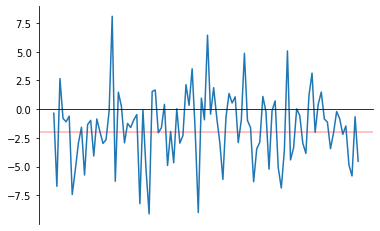

In [10]:
# plotting some inputs

inputs, targets, masks, coh_trials = generate_trials(200)

fig, ax = plt.subplots()
ax.plot(inputs[0, :, 0])
ax.axhline(coh_trials[0], c='r', alpha=.3)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_visible(False)
ax.set_xticks([])
plt.show()

# Writing the training function

In order to train a network, we need an error function. When receiving some input data $\{x_{p,t,k}\}$ ($p$ is the trial number, $t$ the timestep, $k$ the input dimension of which there is only one in our case), our network will produce outputs $\{z_{p, t, l}\}$, that we want to match the target output $\{z^*_{p, t, l}\}$ whenever the mask $\{M_{p, t, l}\}$ is not zero. We can use as an error function the mean quadratic error (with $P$ the number of trials):

$$\mathcal{L}=\frac{1}{P} \sum_{p, t, l} M_{p, t, l}\left(z_{p, t, l}- z^*_{p, t, l}\right)^{2}$$

The magic behind pytorch is that we will write the code computing this error function from the output tensor of the network, and it will by itself modify the values of the parameters of the network to minimize this error via a gradient descent algorithm.

In [11]:
# Complete the following function returning the error

def error_function(outputs, targets, masks):
    """
    parameters:
    outputs: torch tensor of shape (n_trials x duration x output_dim)
    targets: torch tensor of shape (n_trials x duration x output_dim)
    mask: torch tensor of shape (n_trials x duration x output_dim)
    
    returns: float
    """
    return torch.sum(masks * (targets - outputs)**2) / outputs.shape[0]

In [14]:
def train(net, inputs, targets, masks, n_epochs, lr, batch_size=32):
    n_trials = inputs.shape[0]
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # fancy gradient descent algorithm
    losses = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        random_batch_idx = random.sample(range(n_trials), batch_size)
        batch = inputs[random_batch_idx]
        _, output = net.forward(batch)
        loss = error_function(output, targets[random_batch_idx], masks[random_batch_idx])
        loss.backward()  # with this function, pytorch computes the gradient of the loss with respect to all the parameters
        optimizer.step()  # here it applies a step of gradient descent
        
        losses.append(loss.item())
        print(f'Epoch {epoch}, loss={loss:.3f}')
        loss.detach_()  # 2 lines for pytorch administration
        output.detach_()
        
    return losses

The critical part when training a network is to find the right combination of hyperparameters (learning rate, initial conditions, maybe regularization...) to make it converge to a satisfying solution. Here I help you by setting a low standard deviation for the connectivity matrix, try to find a good learning rate so that the loss attains less than 0.1.

Epoch 0, loss=157.507
Epoch 1, loss=283.752
Epoch 2, loss=46.426
Epoch 3, loss=37.009
Epoch 4, loss=60.029
Epoch 5, loss=9.925
Epoch 6, loss=3.982
Epoch 7, loss=23.889
Epoch 8, loss=21.992
Epoch 9, loss=6.562
Epoch 10, loss=1.731
Epoch 11, loss=3.926
Epoch 12, loss=6.007
Epoch 13, loss=5.151
Epoch 14, loss=4.708
Epoch 15, loss=0.835
Epoch 16, loss=2.989
Epoch 17, loss=2.691
Epoch 18, loss=4.558
Epoch 19, loss=4.082
Epoch 20, loss=2.107
Epoch 21, loss=0.274
Epoch 22, loss=0.642
Epoch 23, loss=1.942
Epoch 24, loss=2.350
Epoch 25, loss=1.644
Epoch 26, loss=2.280
Epoch 27, loss=1.118
Epoch 28, loss=0.565
Epoch 29, loss=0.426
Epoch 30, loss=1.473
Epoch 31, loss=1.210
Epoch 32, loss=1.060
Epoch 33, loss=0.473
Epoch 34, loss=0.266
Epoch 35, loss=0.254
Epoch 36, loss=0.681
Epoch 37, loss=0.752
Epoch 38, loss=0.745
Epoch 39, loss=0.409
Epoch 40, loss=0.222
Epoch 41, loss=0.071
Epoch 42, loss=0.147
Epoch 43, loss=0.422
Epoch 44, loss=0.557
Epoch 45, loss=0.390
Epoch 46, loss=0.228
Epoch 47, loss

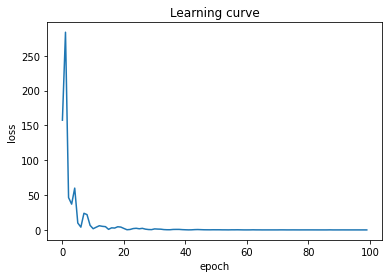

In [23]:
inputs, targets, masks, coh_trials = generate_trials(200)

net_size = 128
deltaT = .2
my_net = RNN(1, net_size, 1, deltaT, .1)
losses = train(my_net, inputs, targets, masks, 100, 1e-2)  # you have to find a good learning rate ! (try negative power of 10)

plt.plot(np.arange(len(losses)), losses)
plt.title('Learning curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# Analyzing the trained network

## Accuracy

In [31]:
def accuracy(net):
   n_trials = 100
   inputs_pos, _, _, _ = generate_trials(n_trials, coherences=[+1])
   inputs_neg, _, _, _ = generate_trials(n_trials, coherences=[-1])
   _, outputs_pos = net.forward(inputs_pos)
   _, outputs_neg = net.forward(inputs_neg)
   outputs_pos = outputs_pos.detach().numpy().squeeze()
   outputs_neg = outputs_neg.detach().numpy().squeeze()
   acc_pos = np.sum(outputs_pos[:, -1] > 0) / 100
   acc_neg = np.sum(outputs_neg[:, -1] < 0) / 100
   return (acc_pos + acc_neg) / 2

print(accuracy(my_net))

0.995


## Condition-averaged responses

Generate 100 trials for coherences +1 and -1, and plot the mean response of the network along the individual trajectories.

Text(0, 0.5, 'network readout')

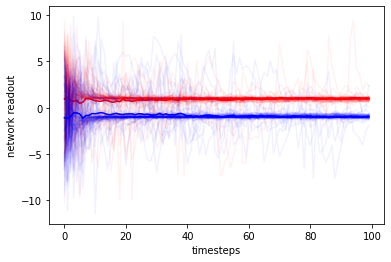

In [24]:
inputs_pos, _, _, _ = generate_trials(100, coherences=[+1])
inputs_neg, _, _, _ = generate_trials(100, coherences=[-1])

# run network
traj_pos, output_pos = ...
traj_neg, output_neg = ...

# convert from voltages to firing rates
traj_pos = ...
traj_neg = ...

# convert all tensors to numpy
traj_pos = traj_pos.detach().numpy().squeeze()
output_pos = output_pos.detach().numpy().squeeze()
traj_neg = traj_neg.detach().numpy().squeeze()
output_neg = output_neg.detach().numpy().squeeze()

# condition averaging
mean_traj_pos = ...
mean_traj_neg = ...
mean_output_pos = ...
mean_output_neg = ...

plt.plot(mean_output_pos, c='r')
for i in range(output_pos.shape[0]):
    plt.plot(output_pos[i], c='r', alpha=.05)

plt.plot(mean_output_neg, c='b')
for i in range(output_neg.shape[0]):
    plt.plot(output_neg[i], c='b', alpha=.05)
    
plt.xlabel('timesteps')
plt.ylabel('network readout')

Same for individual neurons

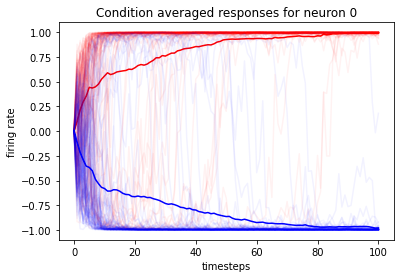

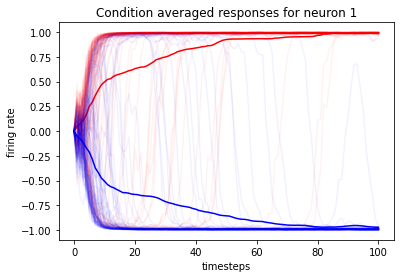

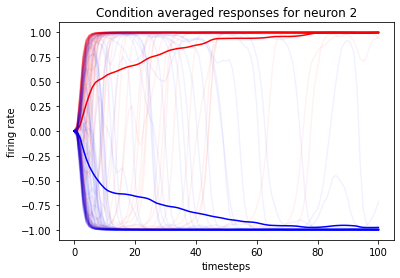

In [25]:
def plot_neuron_condition_averaged(neuron_idx, traj_pos, traj_neg, mean_traj_pos, mean_traj_neg):
    plt.plot(mean_traj_pos[:, neuron_idx], c='r')
    for i in range(traj_pos.shape[0]):
        plt.plot(traj_pos[i, :, neuron_idx], c='r', alpha=.05)

    plt.plot(mean_traj_neg[:, neuron_idx], c='b')
    for i in range(traj_neg.shape[0]):
        plt.plot(traj_neg[i, :, neuron_idx], c='b', alpha=.05)
    plt.xlabel('timesteps')
    plt.ylabel('firing rate')
    plt.title(f'Condition averaged responses for neuron {neuron_idx}')
    plt.show()
    
    
plot_neuron_condition_averaged(0, traj_pos, traj_neg, mean_traj_pos, mean_traj_neg)
plot_neuron_condition_averaged(1, traj_pos, traj_neg, mean_traj_pos, mean_traj_neg)
plot_neuron_condition_averaged(2, traj_pos, traj_neg, mean_traj_pos, mean_traj_neg)

Although individual responses are very noisy, by averaging responses by condition it appears clearly that all neurons seem to be doing an integration of the input signal until they saturate. It hence seems that the activity of all neurons in the network are correlated. In other words, the population activity $\phi(\mathbf{x}) = \{\phi(x_i)\}$ does not explore the whole N-dimensional space available to it, but stays confined to a low-dimensional subspace of activity.

To retrieve this subspace, one can apply unsupervised dimensionality reduction techniques like PCA on responses to a set of random inputs.

In [26]:
from sklearn.decomposition import PCA

# Generate responses to random trials
inputs, _, _, _ = generate_trials(100)
traj, outputs = my_net.forward(inputs)
traj = torch.tanh(traj)
traj = traj.detach().numpy().squeeze()
outputs = outputs.detach().numpy().squeeze()

pca = PCA()

# PCA can only reduce 2-dimensional data. Here we have a 3-dimensional tensor of shape (n_trials x duration x net_size)
# Reshape it to a 2d tensor of shape ((n_trials x duration)  x net_size) (ie. concatenating different trials along the time axis)
traj_2d = ...
print(traj_2d.shape)
pca.fit(traj_2d)


(10100, 128)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Plot the cumulative explained variance ratio explained by the first 20 components of the PCA. (we add a trailing zero to better visualize the gain in variance offered by the first component)

Text(0, 0.5, 'cum. explained variance ratio')

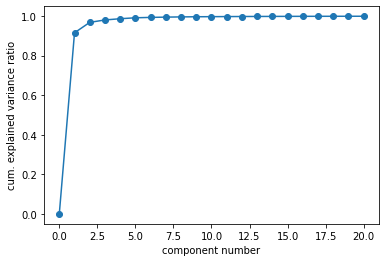

In [27]:
cum_var_exp_ratio = ...
cum_var_exp_ratio = np.concatenate([np.zeros(1), cum_var_exp_ratio]) # add a trailing zero to visualize first component

plt.plot(np.arange(21), cum_var_exp_ratio, marker='o')
plt.xlabel('component number')
plt.ylabel('cum. explained variance ratio')

It seems that the 2 first PCA directions explain a big chunk of the neural activity in our network. Let us project the responses to positive and negative trials generated earlier on those directions. We can then plot the trajectories on this 2D subspace.

Text(0, 0.5, 'PCA axis 2')

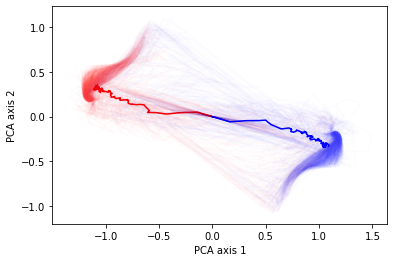

In [28]:
pca_axis1 = pca.components_[:, 0]
pca_axis2 = pca.components_[:, 1]

# Do it for individual trial tensor data
traj_pos_pca1 = ...
traj_pos_pca2 = ...
traj_neg_pca1 = ...
traj_neg_pca2 = ...

# Same for condition averaged trajectories:
mean_traj_pos_pca1 = ...
mean_traj_pos_pca2 = ...
mean_traj_neg_pca1 = ...
mean_traj_neg_pca2 = ...

# Plot trajectories
plt.plot(..., ..., c='r')
for i in range(output_pos.shape[0]):
    plt.plot(..., ..., c='r', alpha=.01)

plt.plot(..., ..., c='b')
for i in range(output_neg.shape[0]):
    plt.plot(..., ..., c='b', alpha=.01)
    
plt.xlabel('PCA axis 1')
plt.ylabel('PCA axis 2')

# Resources

* [Hands-on book by Michael Nielsen (create your own neural network from scratch)](http://neuralnetworksanddeeplearning.com/)
* [Goodfellow-Bengio-Courville: the reference textbook](https://www.deeplearningbook.org/)
* [pytorch's 60 minute blitz to get started](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
  * [in particular, training a convolutional neural net for vision](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
  * [and lots of example codes](https://github.com/pytorch/examples)
* [Deep learning in neuroscience: a review](https://arxiv.org/pdf/2006.01001.pdf)
  * [with its notebook examples](https://github.com/gyyang/nn-brain)
* [An example of neural net for language generation (level ++) (code not for python but good to get started)](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
  * [Also this](https://www.kaggle.com/ab971631/beginners-guide-to-text-generation-pytorch)
* [An example of reinforcement learning (level +++)](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

And much more than you could ever read, just be curious! 